# Monte Carlo Simulation Class

In [52]:
import numpy as np
import pandas as pd
from pandas_datareader import data as wb
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import yfinance as yf
from datetime import datetime, timedelta

In [53]:
class MonteCarlo:
    
    def __init__(self, ticker, start_date, end_date, days, sim):
        self.ticker = ticker
        self.start = start_date
        self.end = end_date
        self.noOfSimulations = sim
        self.noOfDays = days
        
        self.download_stock_data()
        self.read_csv_file()
        self.calc_log_returns()
        self.volatility_calc()
        self.run_monteCarlo()

    def download_stock_data(self):
        try:
            # Using Yahoo Finance to get stock data
            self.stock = yf.Ticker(self.ticker)
            self.data = self.stock.history(start=self.start, end=self.end)
        
            # Verify that the data has been downloaded correctly
            if self.data.empty:
                print(f"No data found for ticker {self.ticker}. It may have been delisted.")
                return
            
            self.csv_file_path = f'{self.ticker}_stock_data.csv'
            self.data.to_csv(self.csv_file_path, sep=',', index=True)  # Also save the index to have the dates
            
            print(f"Data for {self.ticker} saved to {self.csv_file_path}.")
    
        except Exception as e:
            print(f"An error occurred while importing data for {self.ticker}: {e}")

    def read_csv_file(self):
        try:
            # Leggi il file CSV in un DataFrame
            self.data = pd.read_csv(self.csv_file_path, delimiter=',')
            print("Data imported from CSV:")
            #print(self.data.head())
        
            # Check if the "Date" or "Timestamp" column is present and rename it to "Timestamp"
            if 'Date' in self.data.columns:
                self.data.columns = self.data.columns.str.replace('Date', 'Timestamp')
        
            # Effettua il parsing della colonna "Timestamp" se è presente
            if 'Timestamp' in self.data.columns:
                self.data['Timestamp'] = pd.to_datetime(self.data['Timestamp'], utc=True)  # Effettua il parsing e gestisci fusi orari misti
        
            # Controlla se la colonna "Price" è presente e rinominala in "Close"
            if 'Price' in self.data.columns:
                self.data.columns = self.data.columns.str.replace('Price', 'Close')
        
            # Rimuovi spazi bianchi dai nomi delle colonne
            self.data.columns = self.data.columns.str.strip()
        
            # Rimuovi spazi bianchi dai valori delle colonne se necessario
            for col in self.data.columns:
                if self.data[col].dtype == 'object':  # Verifica se la colonna è di tipo stringa
                    self.data[col] = self.data[col].str.strip()
        
            # Stampa i dati importati per verificare
            #print("Data after transformations:")
            #print(self.data.head())
        except Exception as e:
            print(f"An error occurred while reading the CSV file for {self.ticker}: {e}")
        
    def calc_log_returns(self):
        # Assuming you're interested in the 'Close' prices
        self.log_returns = np.log(1 + self.data['Close'].pct_change())
        self.log_returns = self.log_returns[1:]

    def volatility_calc(self):
        self.daily_volatility = np.std(self.log_returns)
    
    def run_monteCarlo(self):
        # Get the last day's stock price
        last_price = self.data['Close'].iloc[-1]
        self.last_price = last_price
        
        # Initialize a list to store all simulation results
        all_simulations = []

        for x in range(self.noOfSimulations):
            price_series = [last_price]

            for y in range(1, self.noOfDays):
                price = price_series[-1] * (1 + np.random.normal(0, self.daily_volatility))
                price_series.append(price)

            all_simulations.append(price_series)

        # Convert the list of simulations into a DataFrame all at once
        self.simulation_df = pd.DataFrame(all_simulations).transpose()
                
    def results(self):
        # Extract the prices for the end of the simulation period
        prices = self.simulation_df.iloc[-1]

        # Calculate the 95% confidence interval
        lower_bound = np.percentile(prices, 2.5)
        upper_bound = np.percentile(prices, 97.5)

        # Calculate the mean (expected) price
        mean_price = np.mean(prices)

        # Print the results
        print(f"{self.ticker} actual price: {self.last_price}")
        print(f"{self.ticker} expected price for {self.noOfDays} days later is: {mean_price}")
        print(f"{self.ticker} 95% confidence interval for the price {self.noOfDays} days later is: ({lower_bound}, {upper_bound})")
        #
        
        # Plot the distribution of simulated end prices using seaborn
        plt.figure(figsize=(10, 6))
        sns.histplot(prices, bins=50, kde=True, color='blue')
        plt.axvline(mean_price, color='r', linestyle='--', label=f'Mean: {mean_price:.2f}')
        plt.axvline(lower_bound, color='g', linestyle='--', label=f'2.5% Quantile: {lower_bound:.2f}')
        plt.axvline(upper_bound, color='g', linestyle='--', label=f'97.5% Quantile: {upper_bound:.2f}')
        plt.title(f'Distribution of Simulated Prices for {self.ticker} ({self.noOfDays} days later)')
        plt.xlabel('Price')
        plt.ylabel('Frequency')
        plt.legend()
        plt.grid(True)
        plt.show()

    
        
    def plot(self):
        self.simulation_df.plot(legend=False)
        plt.suptitle(f'Monte Carlo Simulation for: {self.ticker}')
        plt.axhline(y=self.last_price, color='r', linestyle='-')
        plt.xlabel('Day')
        plt.ylabel('Price')
        plt.show()
    
        
    def plot_log_return(self):
        # Plot the log returns
        plt.figure(figsize=(10, 6))
        sns.histplot(self.log_returns, kde=True) # kde=True for plot density
        plt.title(f'Log Return for: {self.ticker}')
        plt.xlabel("Daily Return")
        plt.ylabel("Frequency")
        
    def plot_forecast(self):
        plt.figure(figsize=(12, 8))
        
        # Plot the last 10 days of historical close price
        historical_data = self.data.iloc[-10:]
        plt.plot(historical_data.index, historical_data['Close'], label='Historical Close Price')
        
        # Extend the date index to include the projected future dates
        last_date = self.data.index[-1]
        future_dates = [last_date + timedelta(days=i) for i in range(1, self.noOfDays + 1)]
        
        # Calculate and plot the mean forecast
        mean_forecast = self.simulation_df.mean(axis=1)
        plt.plot(future_dates, mean_forecast, color='green', label='Mean Forecast')
        
        # Plot the last known price as a reference line
        plt.axhline(y=self.last_price, color='r', linestyle='-', label='Last Close Price')

        plt.title(f'Monte Carlo Simulation for: {self.ticker}')
        plt.xlabel('Date')
        plt.ylabel('Price (EUR)')
        plt.legend()
        plt.grid(True)
        plt.show()

Data for AMZ.DE saved to AMZ.DE_stock_data.csv.
Data imported from CSV:
AMZ.DE actual price: 183.13999938964844
AMZ.DE expected price for 20 days later is: 183.57754497680017
AMZ.DE 95% confidence interval for the price 20 days later is: (157.4781476559137, 212.16056117153087)


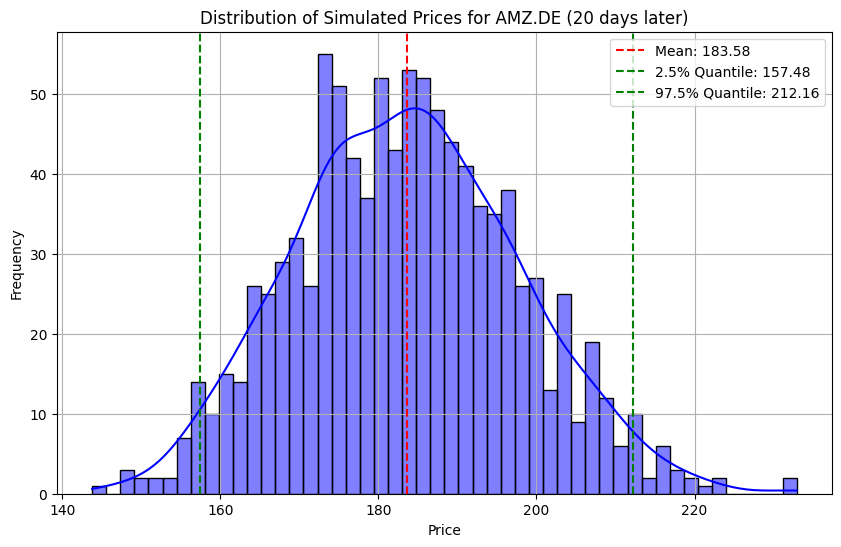

In [54]:
# Define your list of tickers
tickers = ["AMZ.DE"]#, "INTC", "AMD"]

end_date = datetime.now().strftime('%Y-%m-%d')  # Today's date in YYYY-MM-DD format
start_date = (datetime.now() - timedelta(days=2*365)).strftime('%Y-%m-%d')  # Four years before today


# Initialize a dictionary to hold your results
results = {}
forecast_days = 20
num_simulations = 1000

# Loop through each ticker and run the simulation
for ticker in tickers:
    simulation = MonteCarlo(ticker, start_date, end_date, forecast_days, num_simulations)
    simulation.results()
    #simulation.plot_log_return()
    #simulation.plot()
#simulation.plot_total()    